<a href="https://colab.research.google.com/github/shashi912/-Automated-Resume-Screening-Tool/blob/main/AI_Based_Autonomous_Navigation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Generated dataset shape: (20000, 8)

Missing values per column:
 time_idx         0
speed            0
heading          0
yaw_rate         0
acc_lat          0
acc_long         0
obstacle_dist    0
steering         0
dtype: int64

Data summary:
                  count         mean          std        min          25%  \
time_idx       20000.0  9999.500000  5773.647028   0.000000  4999.750000   
speed          20000.0    10.086159     1.506838   6.407367     8.731336   
heading        20000.0    45.262129     7.357909  28.977639    38.422532   
yaw_rate       20000.0     0.001550     1.494061  -6.204143    -1.013984   
acc_lat        20000.0     0.000509     0.086602  -0.317046    -0.065878   
acc_long       20000.0     0.000284     0.157363  -0.449340    -0.131700   
obstacle_dist  20000.0    25.431907     8.708055  10.016600    18.226695   
steering       20000.0    -0.051161     1.891109  -6.431144    -1.432730   

                       50%           75%           max  
time_idx    

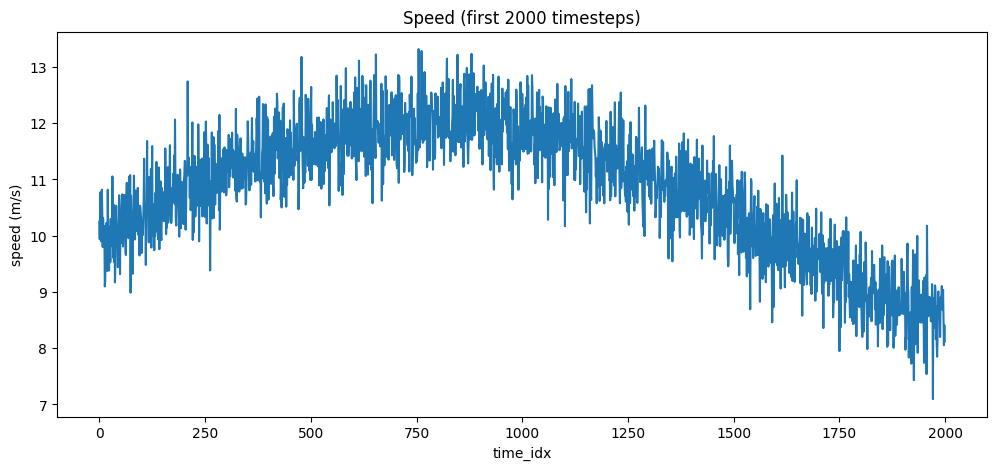

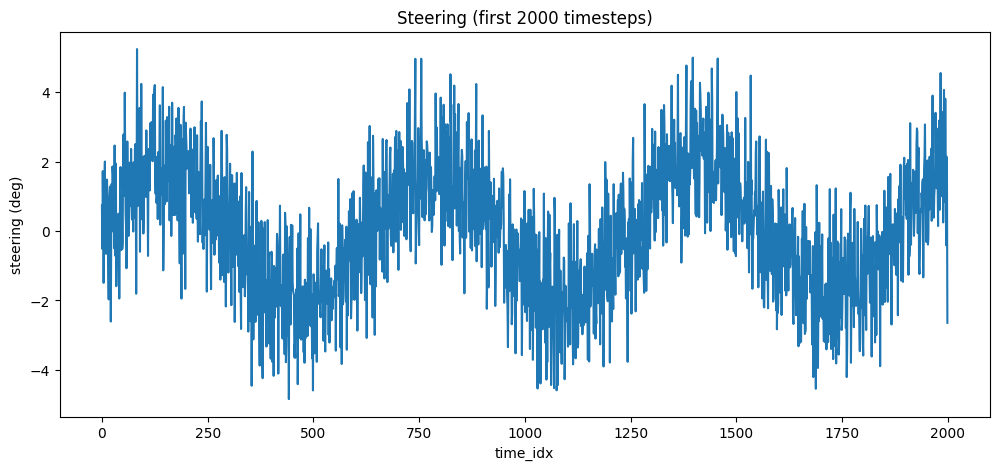

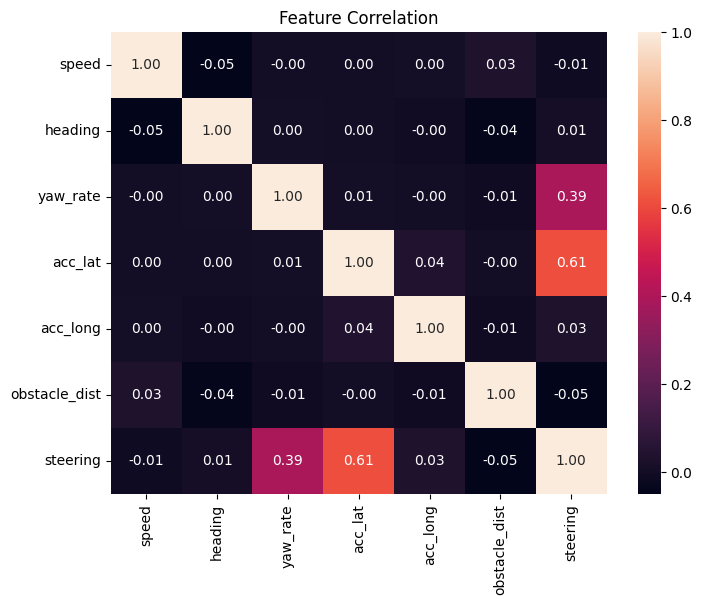


After feature creation shape: (19980, 30)

Train shape: (15984, 27) Test shape: (3996, 27)


TypeError: got an unexpected keyword argument 'squared'

In [2]:
# AI-Based Autonomous Navigation System - end-to-end notebook script
# Run in a Jupyter cell or .py file. Tested with Python 3.10+, TensorFlow 2.x.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
import os
import random
import warnings
warnings.filterwarnings("ignore")

# ------------------------------
# 1) Synthetic dataset generation
# ------------------------------
def generate_synthetic_navigation_data(n_samples=20000, seed=42):
    """
    Generate synthetic time-series navigation data to simulate sensor stream:
    - timestamp (index)
    - speed (m/s)
    - heading (degrees)
    - steering_angle (degrees)  <- target to predict (next-step)
    - acc_lat, acc_long (m/s^2)
    - obstacle_dist (m)
    - yaw_rate (deg/s)
    We'll create some smooth dynamics plus noise so models can learn patterns.
    """
    np.random.seed(seed)
    t = np.arange(n_samples)
    # base speed: random walk around 5-15 m/s (urban + highway mix)
    speed = 10 + 2 * np.sin(0.002 * t) + 0.5 * np.random.randn(n_samples)
    # heading slowly changes
    heading = (45 + 10 * np.sin(0.0015 * t) + 2 * np.random.randn(n_samples)) % 360
    # yaw_rate: derivative of heading + noise
    yaw_rate = np.gradient(heading) + 0.5 * np.random.randn(n_samples)
    # lateral and longitudinal acceleration patterns
    acc_lat = 0.1 * np.sin(0.01 * t) + 0.05 * np.random.randn(n_samples)
    acc_long = 0.2 * np.cos(0.008 * t) + 0.07 * np.random.randn(n_samples)
    # obstacle distance: sometimes close obstacles appearing
    obstacle_dist = 20 + 10 * np.sin(0.003*t) + np.random.exponential(scale=5, size=n_samples)
    # Steering angle target: some function of yaw_rate, heading curvature, obstacle_dist and speed
    # More complex: include interactions and noise
    steering = 0.5 * np.clip(yaw_rate, -10, 10) \
               + 0.2 * (np.sin(0.01 * t) * 10) \
               - 0.05 * (obstacle_dist - 20) / 5 \
               - 0.02 * (speed - 10) \
               + 1.0 * np.random.randn(n_samples)
    # Bound steering to realistic degrees [-45, 45]
    steering = np.clip(steering, -45, 45)
    df = pd.DataFrame({
        "time_idx": t,
        "speed": speed,
        "heading": heading,
        "yaw_rate": yaw_rate,
        "acc_lat": acc_lat,
        "acc_long": acc_long,
        "obstacle_dist": obstacle_dist,
        "steering": steering
    })
    return df

df = generate_synthetic_navigation_data(n_samples=20000)
print("Generated dataset shape:", df.shape)
df.head()

# ------------------------------
# 2) Quick cleaning & sanity checks
# ------------------------------
# Check for missing values (we don't have any in synthetic data, but pipeline should handle)
print("\nMissing values per column:\n", df.isna().sum())

# Remove duplicates on time index if any (none expected)
df = df.drop_duplicates(subset=["time_idx"])
df = df.reset_index(drop=True)

# ------------------------------
# 3) Exploratory Data Analysis (EDA)
# ------------------------------
# Summary statistics
print("\nData summary:\n", df.describe().T)

# Plot some signals
plt.figure(figsize=(12, 5))
plt.plot(df["time_idx"].iloc[:2000], df["speed"].iloc[:2000])
plt.title("Speed (first 2000 timesteps)")
plt.xlabel("time_idx")
plt.ylabel("speed (m/s)")
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(df["time_idx"].iloc[:2000], df["steering"].iloc[:2000])
plt.title("Steering (first 2000 timesteps)")
plt.xlabel("time_idx")
plt.ylabel("steering (deg)")
plt.show()

# Correlation matrix (quick)
plt.figure(figsize=(8, 6))
sns.heatmap(df.drop(columns=["time_idx"]).corr(), annot=True, fmt=".2f")
plt.title("Feature Correlation")
plt.show()

# ------------------------------
# 4) Feature Engineering (time-series style)
# ------------------------------
# Create lag features and rolling statistics (these often help time-series models)
def create_time_features(df, lags=[1,2,3,5], rolling_windows=[5,10,20]):
    df2 = df.copy()
    for lag in lags:
        df2[f"steering_lag_{lag}"] = df2["steering"].shift(lag)
        df2[f"yaw_rate_lag_{lag}"] = df2["yaw_rate"].shift(lag)
        df2[f"speed_lag_{lag}"] = df2["speed"].shift(lag)
    for w in rolling_windows:
        df2[f"steering_roll_mean_{w}"] = df2["steering"].rolling(window=w).mean()
        df2[f"speed_roll_mean_{w}"] = df2["speed"].rolling(window=w).mean()
        df2[f"obstacle_roll_min_{w}"] = df2["obstacle_dist"].rolling(window=w).min()
    # target as next-step steering (predict steering at t+1)
    df2["steering_next"] = df2["steering"].shift(-1)
    return df2

df_feat = create_time_features(df)
# Drop rows with NaNs caused by shifting/rolling
df_feat = df_feat.dropna().reset_index(drop=True)
print("\nAfter feature creation shape:", df_feat.shape)
df_feat.head()

# ------------------------------
# 5) Prepare training data for RandomForest (tabular)
# ------------------------------
# Select features (exclude time_idx, steering, steering_next left as target)
feature_cols = [c for c in df_feat.columns if c not in ["time_idx", "steering", "steering_next"]]
X = df_feat[feature_cols].copy()
y = df_feat["steering_next"].copy()

# Train/test split (time-aware split: last 20% for test)
split_idx = int(0.8 * len(X))
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print("\nTrain shape:", X_train.shape, "Test shape:", X_test.shape)

# Scale features for models that benefit from scaling (LSTM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ------------------------------
# 6) Random Forest Regressor (baseline)
# ------------------------------
rf = RandomForestRegressor(n_estimators=150, max_depth=12, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)
r2_rf = r2_score(y_test, y_pred_rf)
print(f"\nRandomForest RMSE: {rmse_rf:.4f}, R2: {r2_rf:.4f}")

# Plot actual vs predicted (RandomForest)
plt.figure(figsize=(12,5))
plt.plot(y_test.values[:1000], label="Actual", linewidth=1)
plt.plot(y_pred_rf[:1000], label="Predicted (RF)", linewidth=1)
plt.title("Actual vs Predicted Steering (Random Forest) - first 1000 test points")
plt.xlabel("sample index")
plt.ylabel("steering (deg)")
plt.legend()
plt.show()

# ------------------------------
# 7) LSTM model (time-series sequence modeling)
# ------------------------------
# For LSTM we need sequences. We'll use a sliding window on raw sensors + lags
def create_sequences(df_features, target_series, seq_len=10):
    """
    df_features: 2D numpy array (timesteps x features)
    target_series: 1D array (timesteps)
    Returns X_seq shape (n_samples, seq_len, n_features), y_seq shape (n_samples,)
    """
    Xs, ys = [], []
    for i in range(len(df_features) - seq_len):
        Xs.append(df_features[i:(i + seq_len)])
        ys.append(target_series[i + seq_len])  # predict one-step ahead after sequence
    return np.array(Xs), np.array(ys)

# We'll use a subset of columns for LSTM: principal sensors + recent lags (scaled)
lstm_feature_cols = ["speed", "heading", "yaw_rate", "acc_lat", "acc_long", "obstacle_dist",
                     "steering_lag_1", "steering_lag_2", "speed_lag_1"]
X_lstm_all = df_feat[lstm_feature_cols].values
y_lstm_all = df_feat["steering_next"].values

# Scale these features with a separate scaler
lstm_scaler = StandardScaler()
X_lstm_all_scaled = lstm_scaler.fit_transform(X_lstm_all)

SEQ_LEN = 12
X_seq, y_seq = create_sequences(X_lstm_all_scaled, y_lstm_all, seq_len=SEQ_LEN)

# split sequences (use same 80/20 time split)
split_seq_idx = int(0.8 * len(X_seq))
X_seq_train, X_seq_test = X_seq[:split_seq_idx], X_seq[split_seq_idx:]
y_seq_train, y_seq_test = y_seq[:split_seq_idx], y_seq[split_seq_idx:]

print("\nLSTM sequence shapes:", X_seq_train.shape, X_seq_test.shape)

# Build LSTM model
tf.random.set_seed(42)
model = Sequential([
    LSTM(64, input_shape=(SEQ_LEN, X_seq.shape[-1]), return_sequences=False),
    Dropout(0.2),
    Dense(32, activation="relu"),
    Dense(1)
])
model.compile(optimizer="adam", loss="mse", metrics=["RootMeanSquaredError"])
model.summary()

# Train with EarlyStopping
es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)
history = model.fit(X_seq_train, y_seq_train,
                    validation_split=0.15,
                    epochs=40,
                    batch_size=128,
                    callbacks=[es],
                    verbose=1)

# Evaluate LSTM
y_pred_lstm = model.predict(X_seq_test).flatten()
rmse_lstm = mean_squared_error(y_seq_test, y_pred_lstm, squared=False)
r2_lstm = r2_score(y_seq_test, y_pred_lstm)
print(f"\nLSTM RMSE: {rmse_lstm:.4f}, R2: {r2_lstm:.4f}")

# Plot LSTM predictions vs actual (first 1000)
plt.figure(figsize=(12,5))
plt.plot(y_seq_test[:1000], label="Actual", linewidth=1)
plt.plot(y_pred_lstm[:1000], label="Predicted (LSTM)", linewidth=1)
plt.title("Actual vs Predicted Steering (LSTM) - first 1000 test points")
plt.xlabel("sequence index")
plt.ylabel("steering (deg)")
plt.legend()
plt.show()

# ------------------------------
# 8) Compare models on a shared test segment (aligned indices)
# ------------------------------
# Note: RF used tabular features; LSTM used sequence approach and may be misaligned. We'll show both metrics above.
# For feature importance (RF)
importances = rf.feature_importances_
fi = pd.Series(importances, index=feature_cols).sort_values(ascending=False)[:15]
plt.figure(figsize=(8,6))
fi.plot(kind="barh")
plt.title("Top RF feature importances")
plt.gca().invert_yaxis()
plt.show()

# Save minimal artifacts locally (models, scalers) if needed
os.makedirs("artifacts", exist_ok=True)
# Save RF via joblib and scalers via numpy
try:
    import joblib
    joblib.dump(rf, "artifacts/random_forest_rf.pkl")
    joblib.dump(scaler, "artifacts/feature_scaler.pkl")
    lstm_model_path = "artifacts/lstm_model"
    model.save(lstm_model_path)
    print("\nSaved models to /artifacts")
except Exception as e:
    print("Model saving skipped (joblib might not be installed in this environment):", e)

# ------------------------------
# 9) Short conclusions printed
# ------------------------------
print("\n--- Summary of results ---")
print(f"Random Forest: RMSE={rmse_rf:.4f}, R²={r2_rf:.4f}")
print(f"LSTM         : RMSE={rmse_lstm:.4f}, R²={r2_lstm:.4f}")
print("\nInterpretation: Lower RMSE and higher R² indicate better performance. Depending on your deployment constraints (latency, model size), choose the model accordingly. RF is quicker to train and explain; LSTM can capture longer temporal dynamics.")


Generated dataset shape: (20000, 8)


,time_idx,speed,heading,yaw_rate,acc_lat,acc_long,obstacle_dist,steering
0,0,10.248357,45.696572,-0.350854,0.003942,0.246480,21.748281,0.732948
1,1,9.934868,45.581647,-0.763455,0.029145,0.179265,25.771132,-0.515807
2,2,10.331844,43.156960,0.212167,0.019055,0.195313,21.136194,1.725100
3,3,10.773515,46.204168,-0.493278,-0.060896,0.187666,27.768138,0.526957
4,4,9.898923,42.079834,-0.860074,-0.005312,0.235881,20.585466,-1.494858



Missing values per column:
 time_idx         0
speed            0
heading          0
yaw_rate         0
acc_lat          0
acc_long         0
obstacle_dist    0
steering         0
dtype: int64

Data summary:
                  count         mean          std        min          25%  \
time_idx       20000.0  9999.500000  5773.647028   0.000000  4999.750000   
speed          20000.0    10.086159     1.506838   6.407367     8.731336   
heading        20000.0    45.262129     7.357909  28.977639    38.422532   
yaw_rate       20000.0     0.001550     1.494061  -6.204143    -1.013984   
acc_lat        20000.0     0.000509     0.086602  -0.317046    -0.065878   
acc_long       20000.0     0.000284     0.157363  -0.449340    -0.131700   
obstacle_dist  20000.0    25.431907     8.708055  10.016600    18.226695   
steering       20000.0    -0.051161     1.891109  -6.431144    -1.432730   

                       50%           75%           max  
time_idx       9999.500000  14999.250000  19999.

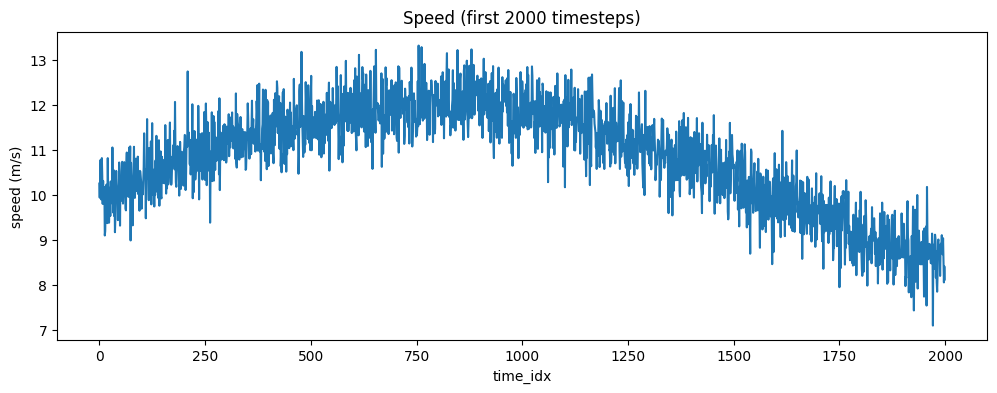

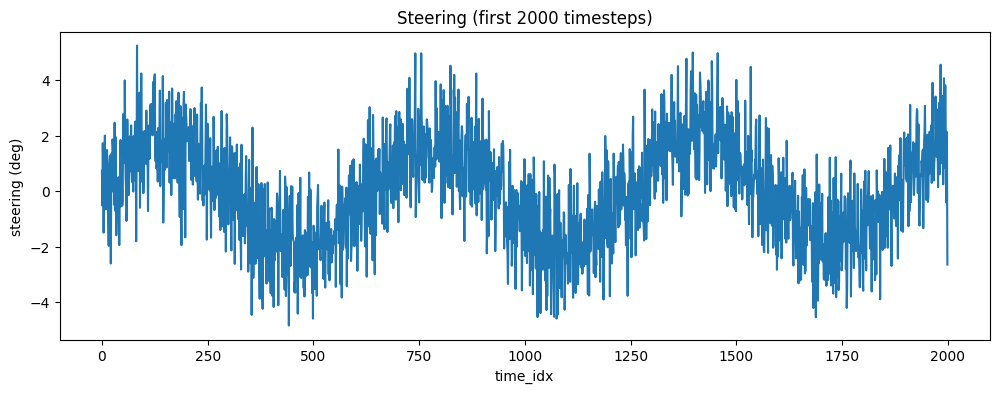

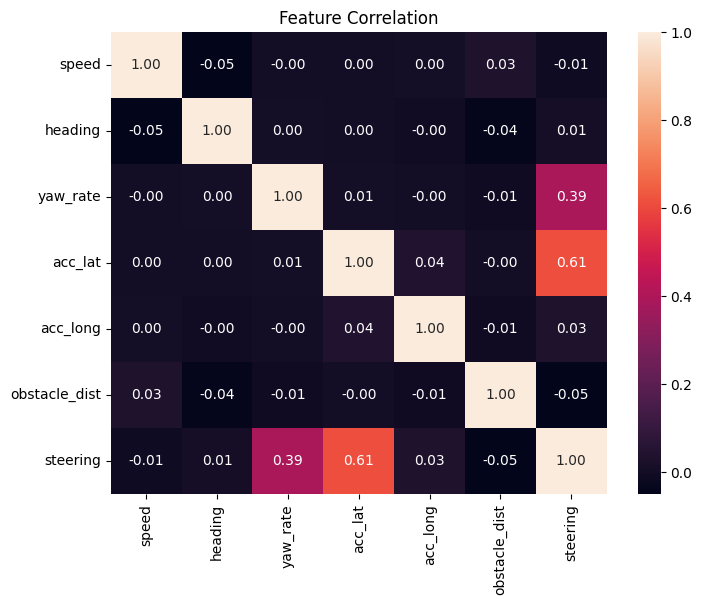


After feature creation shape: (19980, 30)


,time_idx,speed,heading,yaw_rate,acc_lat,acc_long,obstacle_dist,steering,steering_lag_1,yaw_rate_lag_1,...,steering_roll_mean_5,speed_roll_mean_5,obstacle_roll_min_5,steering_roll_mean_10,speed_roll_mean_10,obstacle_roll_min_10,steering_roll_mean_20,speed_roll_mean_20,obstacle_roll_min_20,steering_next
0,19,9.369830,48.926896,3.492118,-0.001161,0.232253,22.787684,1.278418,1.099293,3.344981,...,0.034091,9.709867,20.967953,0.121791,9.662662,20.483096,0.277846,9.952346,20.303653,0.682967
1,20,10.812803,49.726511,-0.718131,0.102565,0.214406,21.384810,0.682967,1.278418,3.492118,...,0.373119,9.916658,20.967953,0.255908,9.763113,20.483096,0.275347,9.980568,20.303653,-2.609189
2,21,9.971087,45.724926,-2.339582,0.062077,0.352324,24.263210,-2.609189,0.682967,-0.718131,...,0.245345,9.999361,21.352233,0.016477,9.779109,20.483096,0.170678,9.982379,20.303653,-0.093569
3,22,10.121736,45.627826,-0.374880,0.058788,0.194055,21.748020,-0.093569,-2.609189,-2.339582,...,0.071584,9.978686,21.352233,-0.140985,9.774385,20.483096,0.079744,9.971874,20.303653,1.357565
4,23,9.379593,44.672291,-0.566240,0.043183,0.036505,27.906003,1.357565,-0.093569,-0.374880,...,0.123238,9.931010,21.384810,-0.073168,9.802809,20.483096,0.121275,9.902178,20.303653,-0.009793



Train shape: (15984, 27) Test shape: (3996, 27)

RandomForest RMSE: 1.2273, R2: 0.5706


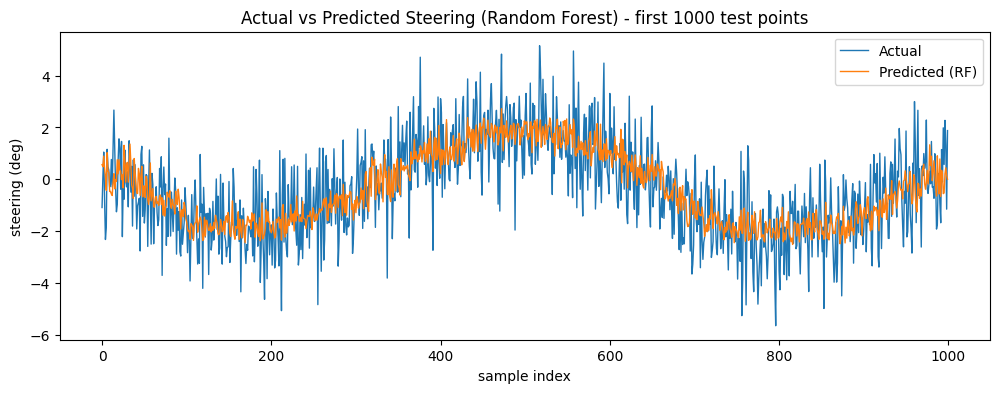


LSTM sequence shapes: (15974, 12, 9) (3994, 12, 9)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        18,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,057 (82.25 KB)

 Trainable params: 21,057 (82.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 2.3173 - root_mean_squared_error: 1.5129 - val_loss: 1.5997 - val_root_mean_squared_error: 1.2648
Epoch 2/40
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 1.5831 - root_mean_squared_error: 1.2580 - val_loss: 1.5730 - val_root_mean_squared_error: 1.2542
Epoch 3/40
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 1.5542 - root_mean_squared_error: 1.2466 - val_loss: 1.5642 - val_root_mean_squared_error: 1.2507
Epoch 4/40
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 1.5457 - root_mean_squared_error: 1.2432 - val_loss: 1.5564 - val_root_mean_squared_error: 1.2476
Epoch 5/40
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 1.5442 - root_mean_squared_error: 1.2425 - val_loss: 1.5604 - val_root_mean_squared_error: 1.2492
Epoch 6/40
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 1.5362 - root_mean_squared_error: 1.2393 - val_loss: 1.5544 - val_root_mean_squared_error: 1.2468
Epoch 7/40
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 20m

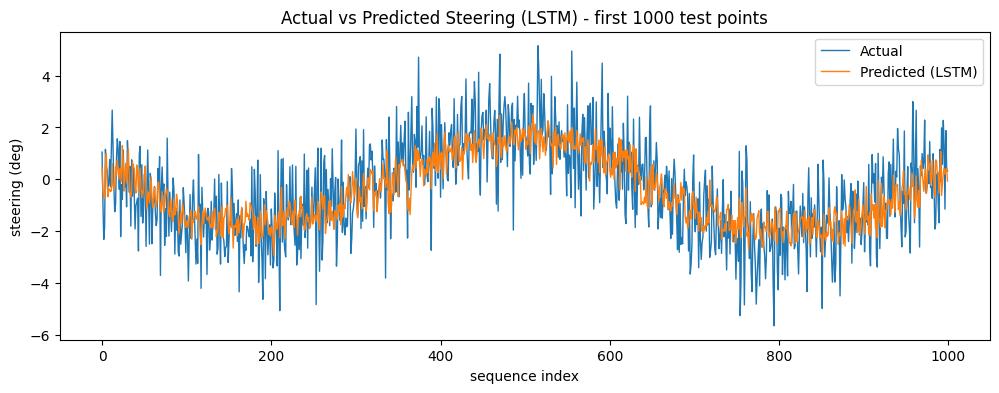

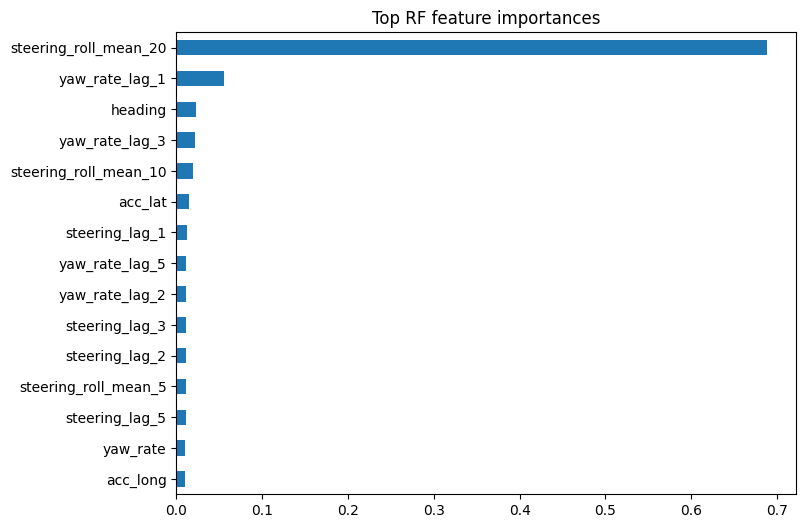

Model saving skipped or failed (joblib/tf may not be available): Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=artifacts/lstm_model.

--- Summary of results ---
Random Forest: RMSE=1.2273, R²=0.5706
LSTM         : RMSE=1.2185, R²=0.5770

Notes: RMSE computed with np.sqrt(mean_squared_error(...)) for broad scikit-learn compatibility.


In [3]:
# AI-Based Autonomous Navigation System - corrected script
# Run in a Jupyter cell or as a .py file. Python 3.8+ recommended.
# Requirements: numpy, pandas, matplotlib, scikit-learn, tensorflow, joblib, seaborn (optional)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
import os
import warnings
warnings.filterwarnings("ignore")

# ------------------------------
# 1) Synthetic dataset generation
# ------------------------------
def generate_synthetic_navigation_data(n_samples=20000, seed=42):
    np.random.seed(seed)
    t = np.arange(n_samples)
    speed = 10 + 2 * np.sin(0.002 * t) + 0.5 * np.random.randn(n_samples)
    heading = (45 + 10 * np.sin(0.0015 * t) + 2 * np.random.randn(n_samples)) % 360
    yaw_rate = np.gradient(heading) + 0.5 * np.random.randn(n_samples)
    acc_lat = 0.1 * np.sin(0.01 * t) + 0.05 * np.random.randn(n_samples)
    acc_long = 0.2 * np.cos(0.008 * t) + 0.07 * np.random.randn(n_samples)
    obstacle_dist = 20 + 10 * np.sin(0.003 * t) + np.random.exponential(scale=5, size=n_samples)
    steering = 0.5 * np.clip(yaw_rate, -10, 10) \
               + 0.2 * (np.sin(0.01 * t) * 10) \
               - 0.05 * (obstacle_dist - 20) / 5 \
               - 0.02 * (speed - 10) \
               + 1.0 * np.random.randn(n_samples)
    steering = np.clip(steering, -45, 45)
    df = pd.DataFrame({
        "time_idx": t,
        "speed": speed,
        "heading": heading,
        "yaw_rate": yaw_rate,
        "acc_lat": acc_lat,
        "acc_long": acc_long,
        "obstacle_dist": obstacle_dist,
        "steering": steering
    })
    return df

df = generate_synthetic_navigation_data(n_samples=20000)
print("Generated dataset shape:", df.shape)
display(df.head())

# ------------------------------
# 2) Cleaning & sanity checks
# ------------------------------
print("\nMissing values per column:\n", df.isna().sum())
df = df.drop_duplicates(subset=["time_idx"]).reset_index(drop=True)

# ------------------------------
# 3) EDA
# ------------------------------
print("\nData summary:\n", df.describe().T)

plt.figure(figsize=(12, 4))
plt.plot(df["time_idx"].iloc[:2000], df["speed"].iloc[:2000])
plt.title("Speed (first 2000 timesteps)")
plt.xlabel("time_idx")
plt.ylabel("speed (m/s)")
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(df["time_idx"].iloc[:2000], df["steering"].iloc[:2000])
plt.title("Steering (first 2000 timesteps)")
plt.xlabel("time_idx")
plt.ylabel("steering (deg)")
plt.show()

plt.figure(figsize=(8,6))
sns.heatmap(df.drop(columns=["time_idx"]).corr(), annot=True, fmt=".2f")
plt.title("Feature Correlation")
plt.show()

# ------------------------------
# 4) Feature Engineering
# ------------------------------
def create_time_features(df, lags=[1,2,3,5], rolling_windows=[5,10,20]):
    df2 = df.copy()
    for lag in lags:
        df2[f"steering_lag_{lag}"] = df2["steering"].shift(lag)
        df2[f"yaw_rate_lag_{lag}"] = df2["yaw_rate"].shift(lag)
        df2[f"speed_lag_{lag}"] = df2["speed"].shift(lag)
    for w in rolling_windows:
        df2[f"steering_roll_mean_{w}"] = df2["steering"].rolling(window=w).mean()
        df2[f"speed_roll_mean_{w}"] = df2["speed"].rolling(window=w).mean()
        df2[f"obstacle_roll_min_{w}"] = df2["obstacle_dist"].rolling(window=w).min()
    df2["steering_next"] = df2["steering"].shift(-1)
    return df2

df_feat = create_time_features(df)
df_feat = df_feat.dropna().reset_index(drop=True)
print("\nAfter feature creation shape:", df_feat.shape)
display(df_feat.head())

# ------------------------------
# 5) Prepare training data (tabular for RF)
# ------------------------------
feature_cols = [c for c in df_feat.columns if c not in ["time_idx", "steering", "steering_next"]]
X = df_feat[feature_cols].copy()
y = df_feat["steering_next"].copy()

# Time-aware train/test split
split_idx = int(0.8 * len(X))
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
print("\nTrain shape:", X_train.shape, "Test shape:", X_test.shape)

# Scale (useful for LSTM later)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ------------------------------
# 6) Random Forest Regressor (baseline)
# ------------------------------
rf = RandomForestRegressor(n_estimators=150, max_depth=12, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Compute RMSE correctly (compatible across sklearn versions)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)
print(f"\nRandomForest RMSE: {rmse_rf:.4f}, R2: {r2_rf:.4f}")

plt.figure(figsize=(12,4))
plt.plot(y_test.values[:1000], label="Actual", linewidth=1)
plt.plot(y_pred_rf[:1000], label="Predicted (RF)", linewidth=1)
plt.title("Actual vs Predicted Steering (Random Forest) - first 1000 test points")
plt.xlabel("sample index")
plt.ylabel("steering (deg)")
plt.legend()
plt.show()

# ------------------------------
# 7) LSTM model (sequence modeling)
# ------------------------------
def create_sequences(df_features, target_series, seq_len=12):
    Xs, ys = [], []
    for i in range(len(df_features) - seq_len):
        Xs.append(df_features[i:(i + seq_len)])
        ys.append(target_series[i + seq_len])
    return np.array(Xs), np.array(ys)

lstm_feature_cols = ["speed", "heading", "yaw_rate", "acc_lat", "acc_long", "obstacle_dist",
                     "steering_lag_1", "steering_lag_2", "speed_lag_1"]
X_lstm_all = df_feat[lstm_feature_cols].values
y_lstm_all = df_feat["steering_next"].values

lstm_scaler = StandardScaler()
X_lstm_all_scaled = lstm_scaler.fit_transform(X_lstm_all)

SEQ_LEN = 12
X_seq, y_seq = create_sequences(X_lstm_all_scaled, y_lstm_all, seq_len=SEQ_LEN)

split_seq_idx = int(0.8 * len(X_seq))
X_seq_train, X_seq_test = X_seq[:split_seq_idx], X_seq[split_seq_idx:]
y_seq_train, y_seq_test = y_seq[:split_seq_idx], y_seq[split_seq_idx:]

print("\nLSTM sequence shapes:", X_seq_train.shape, X_seq_test.shape)

# Build LSTM
tf.random.set_seed(42)
model = Sequential([
    LSTM(64, input_shape=(SEQ_LEN, X_seq.shape[-1]), return_sequences=False),
    Dropout(0.2),
    Dense(32, activation="relu"),
    Dense(1)
])
model.compile(optimizer="adam", loss="mse", metrics=[tf.keras.metrics.RootMeanSquaredError()])
model.summary()

es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)
history = model.fit(X_seq_train, y_seq_train,
                    validation_split=0.15,
                    epochs=40,
                    batch_size=128,
                    callbacks=[es],
                    verbose=1)

# Evaluate LSTM
y_pred_lstm = model.predict(X_seq_test).flatten()
rmse_lstm = np.sqrt(mean_squared_error(y_seq_test, y_pred_lstm))
r2_lstm = r2_score(y_seq_test, y_pred_lstm)
print(f"\nLSTM RMSE: {rmse_lstm:.4f}, R2: {r2_lstm:.4f}")

plt.figure(figsize=(12,4))
plt.plot(y_seq_test[:1000], label="Actual", linewidth=1)
plt.plot(y_pred_lstm[:1000], label="Predicted (LSTM)", linewidth=1)
plt.title("Actual vs Predicted Steering (LSTM) - first 1000 test points")
plt.xlabel("sequence index")
plt.ylabel("steering (deg)")
plt.legend()
plt.show()

# ------------------------------
# 8) RF feature importances & artifacts saving
# ------------------------------
importances = rf.feature_importances_
fi = pd.Series(importances, index=feature_cols).sort_values(ascending=False)[:15]
plt.figure(figsize=(8,6))
fi.plot(kind="barh")
plt.title("Top RF feature importances")
plt.gca().invert_yaxis()
plt.show()

os.makedirs("artifacts", exist_ok=True)
try:
    import joblib
    joblib.dump(rf, "artifacts/random_forest_rf.pkl")
    joblib.dump(scaler, "artifacts/feature_scaler.pkl")
    model.save("artifacts/lstm_model")
    print("\nSaved models to artifacts/")
except Exception as e:
    print("Model saving skipped or failed (joblib/tf may not be available):", e)

# ------------------------------
# 9) Summary
# ------------------------------
print("\n--- Summary of results ---")
print(f"Random Forest: RMSE={rmse_rf:.4f}, R²={r2_rf:.4f}")
print(f"LSTM         : RMSE={rmse_lstm:.4f}, R²={r2_lstm:.4f}")
print("\nNotes: RMSE computed with np.sqrt(mean_squared_error(...)) for broad scikit-learn compatibility.")
